<a href="https://colab.research.google.com/github/rmorlowski/Artificial-Intelligence-Deep-Learning/blob/master/MNIST_Neural_Networks_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST Neural Networks

This individual assignment involves fitting a neural network to the MNIST data, testing alternative network structures, activation functions, optimization methods, and/or hyperparameter settings. For these models, classification performance, accuracy and processing time will be compared across experiments.

**The Benchmark Experiment: ** This assignment concerns a single hidden layer. See what happens when you change the number of nodes in that single hidden layer, going from one to two nodes, and from two to many nodes. Note that having a single layer with a single node is similar to employing what is known as a multinomial logit model (logistic regression if there are only two classes).  Due to the time required to fit each neural network, we will observe only one trial for each cell in the design. Also, we will be using a simple training-and-test split with the split having been performed previously. That is, we use the training and test sets that come with MNIST.

Relevant documentation includes:

*   [Agéron, handson-ml](https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb)
*   [Chollet - Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb)
*   [TensorFlow Tutorials](https://www.tensorflow.org/tutorials)
*   [Visualizing Weights and Convolutions](https://github.com/keras-team/keras/issues/431)

An example experiment could include two values for the number of nodes per inner layer and two values for the number of inner layers. Various machine learning hyperparameter settings may be used.


---


### Section 1: Ingest - Data Survey

For this assignment we will develop a neural network classifier that may be used to predict which of the ten digits is being written.


First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [57]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import time
from sklearn.neural_network import MLPClassifier
from tensorboardcolab import *

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
import pandas as pd
import statsmodels.formula.api as smf  # R-like model specification
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, make_scorer 
from sklearn.model_selection import cross_val_score, train_test_split

Setup ngrok and run TensorBoard in Colab

In [62]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-04-16 19:41:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.206.9.96, 52.203.102.189, 52.207.111.186, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.206.9.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  14.28M  15.5MB/s    in 0.9s    

2019-04-16 19:41:50 (15.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
log_dir = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

**MNIST Dataset**

Gather data for the MNIST dataset.  These data consist of 70 thousand observations. Utilize the first 60 thousand as a model development set and the final 10 thousand as a holdout test set.

Load Train/Test split of the dataset in preparation for modeling.  Split the MNIST dataset into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [0]:
#split train & test data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

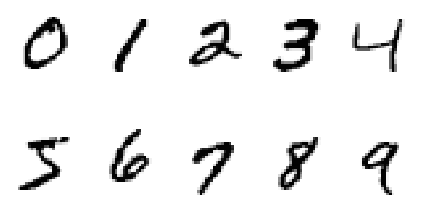

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

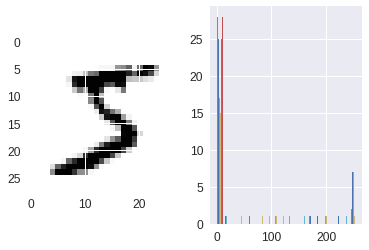

In [67]:
# Let's plot an image and histogram to quickly visualize the pixel data.
%matplotlib inline

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);

ax2.hist(X_train[0], bins=20, range=[0,255]);

The large number of 0 values correspond to the background of the image, another large mass of value 255 is black, and a mix of grayscale transition values in between. Both the image and histogram look sensible. But, it's good practice when training image models to normalize values to be centered around 0.

We'll do that next. The normalization code is fairly short, and it may be tempting to assume we haven't made mistakes, but we'll double-check by looking at the rendered input and histogram again. Malformed inputs are a surprisingly common source of errors when developing new models.

#### Scale Data

In [0]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [0]:
# scale the data for use in the neural network
X_train = X_train / 255
X_test = X_test / 255

In [70]:
#test split 'train'
X_train.shape

(60000, 784)

In [71]:
#test split 'test'
X_test.shape

(10000, 784)

### Section 2: EDA

#### Visualize MNIST

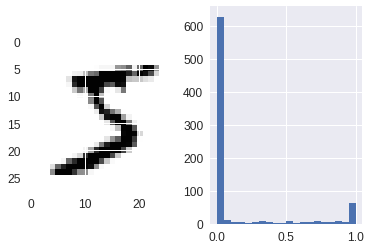

In [72]:
# We again plot the image and histogram to check that we 
# haven't mangled the data.
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.hist(X_train[0], bins=20, range=[0, 1]);

We've retained the correct image data while properly rescaling to the range [0, 1.0].

Training data shape (60000, 784)


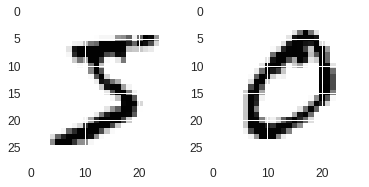

In [73]:
#check data in training set as visual:
print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

In [0]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [0]:
#define confusion matrix plot
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [76]:
X_train.dtype

dtype('float32')

### Section 3: Modeling - Neural Networks

In summary, this assignment asks you to fit a number of neural networks, comparing processing time and performance across experimental treatments.

#### Baseline Keras Model MLP

In [0]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [85]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
# build the model
model = baseline_model()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 0.2761 - acc: 0.9213 - val_loss: 0.1414 - val_acc: 0.9581
Epoch 2/10
 - 1s - loss: 0.1091 - acc: 0.9687 - val_loss: 0.0933 - val_acc: 0.9712
Epoch 3/10
 - 1s - loss: 0.0713 - acc: 0.9790 - val_loss: 0.0785 - val_acc: 0.9762
Epoch 4/10
 - 1s - loss: 0.0493 - acc: 0.9857 - val_loss: 0.0680 - val_acc: 0.9806
Epoch 5/10
 - 1s - loss: 0.0358 - acc: 0.9900 - val_loss: 0.0653 - val_acc: 0.9792
Epoch 6/10
 - 1s - loss: 0.0264 - acc: 0.9930 - val_loss: 0.0599 - val_acc: 0.9811
Epoch 7/10
 - 1s - loss: 0.0190 - acc: 0.9954 - val_loss: 0.0636 - val_acc: 0.9808
Epoch 8/10
 - 1s - loss: 0.0154 - acc: 0.9963 - val_loss: 0.0567 - val_acc: 0.9814
Epoch 9/10
 - 1s - loss: 0.0103 - acc: 0.9980 - val_loss: 0.0586 - val_acc: 0.9820
Epoch 10/10
 - 1s - loss: 0.0075 - acc: 0.9987 - val_loss: 0.0658 - val_acc: 0.9796
Baseline Error: 2.04%


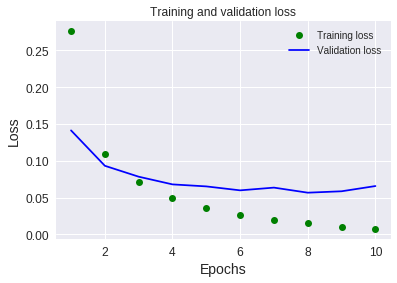

In [79]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

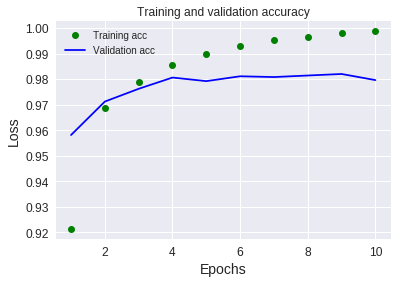

In [80]:
# Plotting the training and validation accuracy
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
# Visualizing weights and convolutions
def get_activations(model, model_inputs, print_shape_only=True, layer_name=None):
    import keras.backend as K
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(1.)
    else:
        list_inputs = [model_inputs, 1.]

    # Learning phase. 1 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 1.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [83]:
activations = get_activations(model, X_test)

----- activations -----
(10000, 784)
(10000, 10)


In [84]:
print(activations[0])

[[1.1413105  0.03427291 0.         ... 0.         0.22211531 0.51732314]
 [0.09886524 0.         1.3459632  ... 0.         0.         0.        ]
 [0.         1.1000751  0.38208482 ... 0.         0.         0.        ]
 ...
 [0.7516961  0.         0.         ... 0.5033345  1.1827773  0.        ]
 [0.45841402 0.         0.6854541  ... 0.         0.         0.        ]
 [0.90652484 1.181271   0.36761758 ... 0.         0.         0.        ]]


#### Tensorflow DNNClassifier Version - 2D with 10 Neurons per layer

Begin by setting the neural network parameters, the number of layers, and the number of neurons per layer.

In [0]:
#Model 2a - 2D with 10 Neurons each layer
%%time
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf_2a = tf.estimator.DNNClassifier(hidden_units=[10,10], n_classes=10,
                                     feature_columns=feature_cols)

input_fn_2a = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=50, batch_size=50, shuffle=True)
dnn_clf_2a.train(input_fn=input_fn_2a)

In [0]:
#evaluate training accuracy (2a)
train_2a_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
eval_results_train_2a = dnn_clf_2a.evaluate(input_fn=train_2a_input_fn)
eval_results_train_2a

In [0]:
#evaluate test accuracy (2a)
test_2a_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results_test_2a = dnn_clf_2a.evaluate(input_fn=test_2a_input_fn)
eval_results_test_2a

In [0]:
#confusion matrix for 2a predictions
raw_predictions_2a = dnn_clf_2a.predict(input_fn=test_2a_input_fn)
predictions_2a = [p['class_ids'][0] for p in raw_predictions_2a]
confusion_matrix_2a = tf.confusion_matrix(y_test, predictions_2a)

with tf.Session():
    print('\nConfusion Matrix model 2a:\n', tf.Tensor.eval(confusion_matrix_2a,feed_dict=None, session=None))

#### Tensorflow DNNClassifier Version - 2D with 20 Neurons per layer

(2) Model 2 - 2 layers with 20 nodes per layer

In [0]:
#Model 2b - 2D with 20 Neurons each layer
%%time
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf_2b = tf.estimator.DNNClassifier(hidden_units=[20,20], n_classes=10,
                                     feature_columns=feature_cols)

input_fn_2b = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=50, batch_size=50, shuffle=True)
dnn_clf_2b.train(input_fn=input_fn_2b)

In [0]:
#evaluate training accuracy (2b)
train_2b_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
eval_results_train_2b = dnn_clf_2a.evaluate(input_fn=train_2b_input_fn)
eval_results_train_2b

In [0]:
#evaluate test accuracy (2b)
test_2b_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results_test_2b = dnn_clf_2b.evaluate(input_fn=test_2a_input_fn)
eval_results_test_2b

#### Tensorflow DNNClassifier Version - 5D with 20 Neurons per layer

(3) Model 3 - 5 layers with 20 nodes per layer

In [0]:
#Model 5a - 5D with 20 Neurons each layer
%%time
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf_5a = tf.estimator.DNNClassifier(hidden_units=[20,20,20,20,20], n_classes=10,
                                     feature_columns=feature_cols)

input_fn_5a = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=50, batch_size=50, shuffle=True)
dnn_clf_5a.train(input_fn=input_fn_5a)

In [0]:
#evaluate training accuracy (5a)
train_5a_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
eval_results_train_5a = dnn_clf_5a.evaluate(input_fn=train_5a_input_fn)
eval_results_train_5a

In [0]:
#evaluate test accuracy (5a)
test_5a_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results_test_5a = dnn_clf_5a.evaluate(input_fn=test_5a_input_fn)
eval_results_test_5a

In [0]:
#confusion matrix for 5a predictions
raw_predictions_5a = dnn_clf_5a.predict(input_fn=test_5a_input_fn)
predictions_5a = [p['class_ids'][0] for p in raw_predictions_5a]
confusion_matrix_5a = tf.confusion_matrix(y_test, predictions_5a)

with tf.Session():
    print('\nConfusion Matrix model 5a:\n', tf.Tensor.eval(confusion_matrix_5a,feed_dict=None, session=None))

#### Tensorflow DNNClassifier Version - 5D with 50 Neurons per layer

(4) Model 4 - 5 layers with 50 nodes per layer

In [0]:
#Model 5b - 5D with Mixed Neurons each layer (50,50,50,50,55)
%%time
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf_5b = tf.estimator.DNNClassifier(hidden_units=[50,50,50,50,50], n_classes=10,
                                     feature_columns=feature_cols)

input_fn_5b = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=50, batch_size=50, shuffle=True)
dnn_clf_5b.train(input_fn=input_fn_5b)

In [0]:
#evaluate training accuracy (5b)
train_5b_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
eval_results_train_5b = dnn_clf_5b.evaluate(input_fn=train_5b_input_fn)
eval_results_train_5b

In [0]:
#evaluate test accuracy (5a)
test_5b_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results_test_5b = dnn_clf_5b.evaluate(input_fn=test_5b_input_fn)
eval_results_test_5b

In [0]:
#confusion matrix for 5b predictions
raw_predictions_5b = dnn_clf_5b.predict(input_fn=test_5b_input_fn)
predictions_5b = [p['class_ids'][0] for p in raw_predictions_5b]
confusion_matrix_5b = tf.confusion_matrix(y_test, predictions_5b)

with tf.Session():
    print('\nConfusion Matrix Model 5b:\n', tf.Tensor.eval(confusion_matrix_5b,feed_dict=None, session=None))

In [0]:
tbc=TensorBoardColab()

### Section 4:  Conclusion

**Management problem: ** Regarding the management problem for this assignment. Suppose you are asked to develop a neural network model for digit classification. How would you go about training such a model? How would you judge the model's accuracy in digit classification with real data examples, such as customer or client handwritten digits on paper?

>**Summary Table of Models:**


>Number of Layers | Nodes Per Layer | Processing Time | Train Accuracy | Test Accuracy
>--- | ---
>2 | 10 | 2min 35s | 0.9349 | 0.929
>2 | 20 | 2min 42s | 0.9349 | 0.9555
>5 | 20 | 2min 57s | 0.9858| 0.9582
>5 | 50 | 3min 26s | 0.9944 | 0.9606

**In Conclusion:**

After fitting a number of neural networks, processing time and performance was compared across experimental treatments.

The results showed:

*    The neural network classification model with 5 layers and 50 nodes per layer resulted in the most accurate predictions for handwritten digits.
*    Increasing the number of layers and nodes per layer increased accuracy.
*    As the number of layers and nodes increased, the processing time was slower.

The final recommendation is to implement the neural network classificaiton model with 5 layers and 50 nodes per layer.  Although this model takes longer to process, it results in the most accurate predictions and is the most trustworthy.